# overview

## error identified
I identified 2 major errors in this documents:
- incorret sequence or duplicate info (e.g. Taipei City Taipei City) in the address (in "relation"s)
- info in address doesn't match other fields

## data size
taipei_map.osm 69.7MB

## A copy of my OSM file
https://www.dropbox.com/s/p4tevgig9mo4fh5/taipei_map.osm?dl=0

# Some comments on the dataset

## some problems & potential solutions
- I validate the dataset using different values across each tag. However, when the two tags are in conflict, I have no way to know which one is actually correct. One possible solution is to import external data to validate.
- "address" has a lot of different format. My current setting might be just one of them. If we cannot ensure future entries will follow the same format, we might end up with a database that's still quite a mess.
- The concerns above can also be applied to "name"s.

## other enhancements
- By importing external data like google maps, we can potentially:
    - cross-validate the data to ensure higher accuracy
    - supplement some of the data that we currently don't have
- If we can establish a format for fields like addresses or names, it might just be a lot easier to clean the data and maintain the database schema

## potential problems with the enhacements
- importing external data might be problematic and expensive for the following reason:
    - external data might be stored in different format, and converting format is expensive
    - acquiring external data itself can be expensive, costing us actual money or negotiation time
    - when the external data and our data conflicts, we still don't know how to resolve the conflict
    - external data has its own internal inconsistence, if we wanna import them, we also have to deal with that
- establishing a format to follow might be troublesome for the following reason:
    - we might have no control over the one inputting the data
    - even if we do, it's hard to control human behavior if we don't have any incentive for them

# data loading

In [1]:
from pymongo import MongoClient
import pprint
import xml.etree.ElementTree as et
import xmltodict
import json
from xmljson import badgerfish as bf
from bson.objectid import ObjectId
import matplotlib.pyplot as mt

In [233]:
osm_file = "taipei_map.osm"
# connect to mongodb
client = MongoClient ('mongodb://localhost:27017/')
# indicating database
db=client.tests

# cleaning & then parsing data

In [234]:
db.osm.delete_many({})

## relation

In [235]:
for event, elem in et.iterparse(osm_file,events = ("start",)):
    if elem.tag == "relation":
        result_dict = {}
        result_dict.update({"object_type":"relation"})
        result_dict.update(elem.attrib)
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                if name_split[1] =="full":
                    addr = reformatter(full_addr)
                    addr_dict.update({name_split[1]:addr})
                elif name_split[1] == "city":
                    if a.attrib["v"]!=get_name(full_addr,"city") and get_name(full_addr,"city")!="" and type(get_name(full_addr,"city"))!=None:
                        addr_dict.update({name_split[1]:get_name(full_addr,"city")})
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "street":
                    if a.attrib["v"]!=get_street(full_addr) and get_street(full_addr)!="" and get_street(full_addr) is not None:
                        addr_dict.update({name_split[1]:get_street(full_addr)})
                            #print a.attrib["v"],"xxxx",get_street(full_addr)
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "district":
                    if a.attrib["v"]!=get_name(full_addr,"district") and get_name(full_addr,"district")!="" and type(get_name(full_addr,"district"))!=None:
                        addr_dict.update({name_split[1]:get_name(full_addr,"district")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"district")
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "postcode":
                    if a.attrib["v"]!=get_name(full_addr,"postcode") and get_name(full_addr,"postcode")!="" and get_name(full_addr,"postcode")!="None":
                        addr_dict.update({name_split[1]:get_name(full_addr,"postcode")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"postcode")
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                else:
                    pass
        result_dict.update({"addr":addr_dict})
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                content = a.attrib["v"]
                if name_split[0] != "addr":
                    if name_split[0] in result_dict:
                        if type(result_dict[name_split[0]]) is not dict:
                            result_dict[name_split[0]] = {name_split[0]:result_dict[name_split[0]]}
                        else:
                            pass
                        result_dict[name_split[0]].update({name_split[1]:content})
                    else:
                        result_dict[name_split[0]] = {name_split[1]:content}
                else:
                    pass
            else:
                content = a.attrib["v"]
                result_dict.update({a.attrib["k"]:content})
        db.osm.insert_one(result_dict)

## node

In [236]:
for event, elem in et.iterparse(osm_file,events = ("start",)):
    if elem.tag == "node":
        result_dict = {}
        result_dict.update({"object_type":"node"})
        result_dict.update(elem.attrib)
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                content = a.attrib["v"]
                result_dict[name_split[0]] = {name_split[1]:content}
            else:
                content = a.attrib["v"]
                result_dict.update({a.attrib["k"]:content})
        db.osm.insert_one(result_dict)

## ways

In [237]:
for event, elem in et.iterparse(osm_file,events = ("start",)):
    if elem.tag == "way":
        result_dict = {}
        result_dict.update({"object_type":"way"})
        result_dict.update(elem.attrib)
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                if name_split[1] =="full":
                    addr = reformatter(full_addr)
                    addr_dict.update({name_split[1]:addr})
                elif name_split[1] == "city":
                    if a.attrib["v"]!=get_name(full_addr,"city") and get_name(full_addr,"city")!="" and type(get_name(full_addr,"city"))!=None:
                        addr_dict.update({name_split[1]:get_name(full_addr,"city")})
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "street":
                    if a.attrib["v"]!=get_street(full_addr) and get_street(full_addr)!="" and get_street(full_addr) is not None:
                        addr_dict.update({name_split[1]:get_street(full_addr)})
                            #print a.attrib["v"],"xxxx",get_street(full_addr)
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "district":
                    if a.attrib["v"]!=get_name(full_addr,"district") and get_name(full_addr,"district")!="" and type(get_name(full_addr,"district"))!=None:
                        addr_dict.update({name_split[1]:get_name(full_addr,"district")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"district")
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                elif name_split[1] == "postcode":
                    if a.attrib["v"]!=get_name(full_addr,"postcode") and get_name(full_addr,"postcode")!="" and get_name(full_addr,"postcode")!="None":
                        addr_dict.update({name_split[1]:get_name(full_addr,"postcode")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"postcode")
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                else:
                    pass
        result_dict.update({"addr":addr_dict})
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                content = a.attrib["v"]
                if name_split[0] != "addr":
                    if name_split[0] in result_dict:
                        if type(result_dict[name_split[0]]) is not dict:
                            result_dict[name_split[0]] = {name_split[0]:result_dict[name_split[0]]}
                        else:
                            pass
                        result_dict[name_split[0]].update({name_split[1]:content})
                    else:
                        result_dict[name_split[0]] = {name_split[1]:content}
                else:
                    pass
            else:
                content = a.attrib["v"]
                result_dict.update({a.attrib["k"]:content})
        db.osm.insert_one(result_dict)

# Some basic characterstics of the dataset

In [238]:
db.osm.find_one()

{u'_id': ObjectId('59427bd407ab8845f6971dcf'),
 u'addr': {u'city': u'\u53f0\u5317\u5e02',
  u'district': u'\u58eb\u6797\u5340',
  u'full': u'\u53f0\u5317\u5e02\u58eb\u6797\u5340\u5ef6\u5e73\u5317\u8def\u4e5d\u6bb5212\u865f',
  u'housenumber': u'285',
  u'postcode': u'11174',
  u'street': u'\u5ef6\u5e73\u5317\u8def\u4e5d\u6bb5'},
 u'amenity': u'school',
 u'changeset': u'34823124',
 u'id': u'33574',
 u'name': u'\u897f\u9580\u570b\u5c0f',
 u'object_type': u'relation',
 u'official_name': u'\u81fa\u5317\u5e02\u842c\u83ef\u5340\u897f\u9580\u570b\u6c11\u5c0f\u5b78',
 u'operator': u'\u81fa\u5317\u5e02\u653f\u5e9c\u6559\u80b2\u5c40',
 u'phone': u'+886-2-2389-2182',
 u'timestamp': u'2015-10-23T15:44:41Z',
 u'type': u'multipolygon',
 u'uid': u'1215520',
 u'user': u'bananatw',
 u'version': u'12',
 u'website': u'http://core.hmes.tp.edu.tw/'}

In [239]:
total_in_way = db.osm.find({"object_type":"way"}).count()
total_in_node = db.osm.find({"object_type":"node"}).count()
total_in_relation = db.osm.find({"object_type":"relation"}).count()
print "total count:",total_in_way+total_in_node+total_in_relation
print "way count:",total_in_way
print "node count:",total_in_node
print "relation count:",total_in_relation

total count: 324664
way count: 49121
node count: 272346
relation count: 3197


In [253]:
# num of distinct users
pipeline = [
    {"$match":{"object_type":"way"}},
    {"$group":{"_id":"$user"}},
    {"$group":{"_id":1,"count":{"$sum":1}}}
]
for a in db.osm.aggregate(pipeline):
    print "the num of distinct contributers in way:", a["count"]
pipeline = [
    {"$match":{"object_type":"node"}},
    {"$group":{"_id":"$user"}},
    {"$group":{"_id":1,"count":{"$sum":1}}}
]
for a in db.osm.aggregate(pipeline):
    print "the num of distinct contributers in node:", a["count"]
pipeline = [
    {"$match":{"object_type":"relation"}},
    {"$group":{"_id":"$user"}},
    {"$group":{"_id":1,"count":{"$sum":1}}}
]
for a in db.osm.aggregate(pipeline):
    print "the num of distinct contributers in relation:", a["count"]

the num of distinct contributers in way: 689
the num of distinct contributers in node: 1234
the num of distinct contributers in relation: 103


In [258]:
# the biggest contributer of each category
pipeline = [
    {"$match":{"object_type":"way"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":3}
]
i = 1
for a in db.osm.aggregate(pipeline):
    print "Way ",i,"th contributer:"
    print "name: ",a[u'_id']," ; count:",a[u'count']
    i+=1
print "----------------"
pipeline = [
    {"$match":{"object_type":"node"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":3}
]
i = 1
for a in db.osm.aggregate(pipeline):
    print "Node ",i,"th contributer:"
    print "name: ",a[u'_id']," ; count:",a[u'count']
    i+=1
print "----------------"
pipeline = [
    {"$match":{"object_type":"relation"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":3}
]
i = 1
for a in db.osm.aggregate(pipeline):
    print "Relation ",i,"th contributer:"
    print "name: ",a[u'_id']," ; count:",a[u'count']
    i+=1

Way  1 th contributer:
name:  Supaplex  ; count: 18617
Way  2 th contributer:
name:  mxt305  ; count: 2535
Way  3 th contributer:
name:  Littlebtc  ; count: 2403
----------------
Node  1 th contributer:
name:  Supaplex  ; count: 91348
Node  2 th contributer:
name:  Littlebtc  ; count: 13087
Node  3 th contributer:
name:  愛台玩  ; count: 8297
----------------
Relation  1 th contributer:
name:  Supaplex  ; count: 2299
Relation  2 th contributer:
name:  nyuriks  ; count: 172
Relation  3 th contributer:
name:  Littlebtc  ; count: 116


In [263]:
# top 5 users contribution
pipeline = [
    {"$match":{"object_type":"way"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":5},
    {"$group":{"_id":"top10","count":{"$sum":"$count"}}}
]
for a in db.osm.aggregate(pipeline):
    print "Top 5 contributer combined (in way):",int(a["count"]*1.0/total_in_way*100),"%"

pipeline = [
    {"$match":{"object_type":"node"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":5},
    {"$group":{"_id":"top10","count":{"$sum":"$count"}}}
]
for a in db.osm.aggregate(pipeline):
    print "Top 5 contributer combined (in node):",int(a["count"]*1.0/total_in_node*100),"%"

pipeline = [
    {"$match":{"object_type":"relation"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":5},
    {"$group":{"_id":"top10","count":{"$sum":"$count"}}}
]
for a in db.osm.aggregate(pipeline):
    print "Top 5 contributer combined (in relation):",int(a["count"]*1.0/total_in_relation*100),"%"

Top 5 contributer combined (in way): 55 %
Top 5 contributer combined (in node): 46 %
Top 5 contributer combined (in relation): 83 %


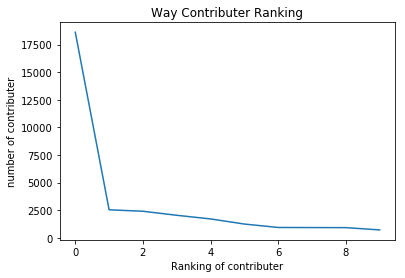

In [265]:
user_ranking = []
pipeline = [
    {"$match":{"object_type":"way"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":10}
]
for a in db.osm.aggregate(pipeline):
    user_ranking.append(a["count"])
mt.plot(user_ranking)
mt.title("Way Contributer Ranking")
mt.xlabel("Ranking of contributer")
mt.ylabel("number of contributer")
mt.show()

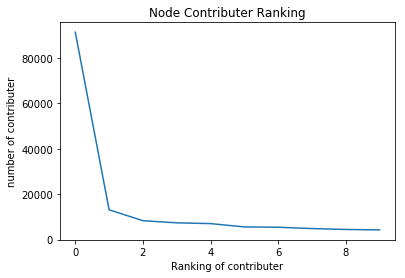

In [267]:
user_ranking = []
pipeline = [
    {"$match":{"object_type":"node"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":10}
]
for a in db.osm.aggregate(pipeline):
    user_ranking.append(a["count"])
mt.plot(user_ranking)
mt.title("Node Contributer Ranking")
mt.xlabel("Ranking of contributer")
mt.ylabel("number of contributer")
mt.show()

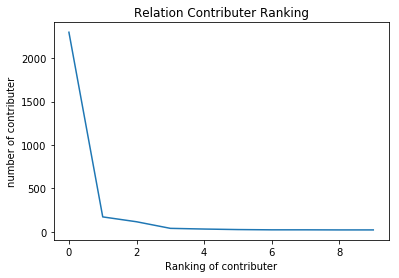

In [268]:
user_ranking = []
pipeline = [
    {"$match":{"object_type":"relation"}},
    {"$group":{"_id":"$user","count":{"$sum":1}}},
    {"$sort":{"count":-1}},
    {"$limit":10}
]
for a in db.osm.aggregate(pipeline):
    user_ranking.append(a["count"])
mt.plot(user_ranking)
mt.title("Relation Contributer Ranking")
mt.xlabel("Ranking of contributer")
mt.ylabel("number of contributer")
mt.show()

# all the functions are here

In [29]:
# this function take a addr, and returns a location dict of each of the elements in a addr
# e.g. city: [0,2] means the "city" part of the addr is located starts from 0 and ends in 2
# in the addr string
def add_location(addr):
    names={
        "district":[u"區"],
        #"village":[u"里",u"村"],
        "road":[u"路"],
        "lane":[u"巷"],
        "alley":[u"弄"],
        "section":[u"段"],
        "city":[u"市"],
        "no":[u"號"],
        "seperator":[ur"(",ur")",ur"[",ur"]",ur" "]
    }
    names_loc={}
    try:
        postcode=int(addr[0:5])
        addr_n=addr[5:]
        loc_pos=5
        location=[0]
        names_loc["postcode"]={1:[4]}
    except:
        try:
            postcode=int(addr[0:3])
            addr_n=addr[3:]
            loc_pos=3
            location=[0]
            names_loc["postcode"]={1:[2]}
        except:
            loc_pos=0
            location=[]
            addr_n=addr
    # make dict of items&locations
    for key,value in names.iteritems():
        for a in value:
            names_loc[key]={}
            loc_e=0
            i=1
            while loc_e<len(addr):
                loc_e=addr_n.find(a,loc_e)
                if loc_e==-1:
                    break
                names_loc[key].update({i:[loc_e+loc_pos]})
                loc_e+=len(a)
                i+=1
    location=[]
    # write all location in a list
    for key,value in names_loc.iteritems():
        for a in value:
            location.append(value[a][0])
    # compare to find repective previous item
    for key,value in names_loc.iteritems():
        i=1
        while i<=len(value):
            cur_loc=value[i][0]
            start_candidate=[cur_loc-a if cur_loc>a and a>=0 else 99 for a in location]
            names_loc[key][i].append(cur_loc-min(start_candidate))
            i+=1
    # eliminate None value
    final={}
    for key,value in names_loc.iteritems():
        if not bool(value):
            pass
        else:
            final.update({key:{}})
            i=1
            while i<=len(value):
                if value[i][1]<0:
                    start=0
                else:
                    start=value[i][1]+1
                final[key].update({i:[start,value[i][0]]})
                i+=1
    return final

# this function takes a addr and reformat them 
# using the previous function
# all the addr will be in the following sequence:
# city, district, street, no
def reformatter(addr):
    loc=add_location(addr)
    def get_name(name):
        return addr[loc[name][1][0]:loc[name][1][1]+1]
    
    # street name (optional)
    try:
        street_full=get_name("road")+get_name("section")
    except:
        try:
            street_full=get_name("road")
        except:
            street_full=""
    # lane & alley (optional)
    try:
        lane_alley=get_name("lane")+get_name("alley")
    except:
        try:
            lane_alley=get_name("lane")
        except:
            lane_alley=""
    # district
    try:
        dis=get_name("district")
    except:
        dis=""
    
    #postcode
    try:
        post=get_name("postcode")
    except:
        post=""
    
    #no
    try:
        num=get_name("no")
    except:
        num=""

    # city
    try:
        city=get_name("city")
    except:
        city=""

    final=city+dis+street_full+lane_alley+num
    return final

# getting some part of the address
def get_name(addr,name):
    loc=add_location(addr)
    try:
        final=addr[loc[name][1][0]:loc[name][1][1]+1]
    except:
        final=None
    return final

# since the "street" part of an addr is more complicated,
# it's retrieved using another function
def get_street(addr):
    loc=add_location(addr)
    def get_name(name):
        return addr[loc[name][1][0]:loc[name][1][1]+1]
    
    # street name (optional)
    try:
        street_full=get_name("road")+get_name("section")
    except:
        try:
            street_full=get_name("road")
        except:
            street_full=""
    # lane & alley (optional)
    try:
        lane_alley=get_name("lane")+get_name("alley")
    except:
        try:
            lane_alley=get_name("lane")
        except:
            lane_alley=""
    try:
        street_all=street_full+lane_alley
    except:
        street_all=street_full
    
    return street_all

def street_formatter(addr):
    loc=add_location(addr)
    def get_name(name):
        return addr[loc[name][1][0]:loc[name][1][1]+1]
    
    # street name (optional)
    try:
        street_full=get_name("road")+get_name("section")
    except:
        try:
            street_full=get_name("road")
        except:
            street_full=""
    # lane & alley (optional)
    try:
        lane_alley=get_name("lane")+get_name("alley")
    except:
        try:
            lane_alley=get_name("lane")
        except:
            lane_alley=""
    try:
        street_all=street_full+lane_alley
    except:
        street_all=street_full
    
    return street_all

In [62]:
db.osm_relation.find_one()

{u'@changeset': 34823124,
 u'@id': 33574,
 u'@timestamp': u'2015-10-23T15:44:41Z',
 u'@uid': 1215520,
 u'@user': u'bananatw',
 u'@version': 12,
 u'_id': ObjectId('593e35d807ab8814e8d184ed'),
 u'member': [{u'@ref': 60793791, u'@role': u'outer', u'@type': u'way'},
  {u'@ref': 364410686, u'@role': u'outer', u'@type': u'way'}],
 u'tag': [{u'@k': u'name', u'@v': u'\u897f\u9580\u570b\u5c0f'},
  {u'@k': u'type', u'@v': u'multipolygon'},
  {u'@k': u'phone', u'@v': u'+886-2-2389-2182'},
  {u'@k': u'amenity', u'@v': u'school'},
  {u'@k': u'website', u'@v': u'http://core.hmes.tp.edu.tw/'},
  {u'@k': u'operator',
   u'@v': u'\u81fa\u5317\u5e02\u653f\u5e9c\u6559\u80b2\u5c40'},
  {u'@k': u'addr:city', u'@v': u'\u81fa\u5317\u5e02'},
  {u'@k': u'addr:full',
   u'@v': u'\u81fa\u5317\u5e02\u842c\u83ef\u5340\u6210\u90fd\u8def98\u865f'},
  {u'@k': u'addr:street', u'@v': u'\u6210\u90fd\u8def'},
  {u'@k': u'addr:country', u'@v': u'TW'},
  {u'@k': u'addr:district', u'@v': u'\u842c\u83ef\u5340'},
  {u'@k': u'

In [84]:
changed = 0
for a in db.osm_relation.find({u"tag.@k":"addr:full"}):
    o_id=a[u'_id']
    for b in a["tag"]:
        if b["@k"]=="addr:full":
            full_addr=b["@v"]
    for b in a["tag"]:
        if b["@k"]=="addr:district":
            if b["@v"]!=get_name(full_addr,"district") and get_name(full_addr,"district")!="" and get_name(full_addr,"district")!=None:
                b["@v"] = get_name(full_addr,"district")
                changed +=1
        if b["@k"]=="addr:street":
            if b["@v"]!=get_street(full_addr) and get_street(full_addr)!="" and get_street(full_addr)!=None:
                b["@v"] = get_street(full_addr)
                changed +=1
        if b["@k"]=="addr:city":
            if b["@v"]!=get_name(full_addr,"city") and get_name(full_addr,"city")!="" and get_name(full_addr,"city")!=None:
                b["@v"] = get_name(full_addr,"city")
                changed +=1
        if b["@k"]=="addr:postcode":
            if b["@v"]!=get_name(full_addr,"postcode") and get_name(full_addr,"postcode")!="" and get_name(full_addr,"postcode")!=None:
                b["@v"] = get_name(full_addr,"postcode")
                changed +=1
    del a[u'_id'];
    db.osm_relation.replace_one({u'_id': o_id},a)
print changed
# changed instance: 17

17


In [80]:
# check for update result
for a in db.osm_relation.find({u"tag.@k":"addr:full"}):
    for b in a["tag"]:
        if b["@k"]=="addr:postcode":
            field=b["@v"]
            print field

10845
10852
10048
10860
10841
10341
11605
11676
10091
10048
10066
11643
11643
116
23554
23554
106
10066
10048
231
111
10663
10465
111
10462
10462
10462
22050
22049
10051
10864
10864
10863
23578
23578
10647
10884
111
10490
10489
10489
10476
110
110
11468
11464
11464
10085
10058
106
10567
111
10351
10081
10048
10582
10048
10058
231
10049
10087
11677
108
23570
11656
11656
11665
104
10066
10074
10066
234
11693
100
114
11031


# backup codes (plz ignore this section)

In [176]:
for event, elem in et.iterparse(osm_file,events = ("start",)):
    result_dict = {}
    if elem.tag == "relation":
        result_dict.update({"object_type":"relation"})
        result_dict.update(elem.attrib)
        for a in elem.iter("tag"):
            if a.attrib["k"].find("addr") != -1:
                addr_bin = True
                addr_dict = {}
            else:
                addr_bin = False
        for a in elem.iter("tag"):
            if a.attrib["k"] == "addr:full":
                full_addr = a.attrib["v"]
        for a in elem.iter("tag"):
            if a.attrib["k"].find(":") != -1:
                name_split = a.attrib["k"].split(":")
                if name_split[0] == "addr":
                    if name_split[1] =="full":
                        addr = reformatter(full_addr)
                        addr_dict.update({name_split[1]:addr})
                        #print addr,"xxx",full_addr
                    elif name_split[1] == "city":
                        if a.attrib["v"]!=get_name(full_addr,"city") and get_name(full_addr,"city")!="" and type(get_name(full_addr,"city"))!=None:
                            addr_dict.update({name_split[1]:get_name(full_addr,"city")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"city")
                        else:
                            addr_dict.update({name_split[1]:a.attrib["v"]})
                    elif name_split[1] == "street":
                        if a.attrib["v"]!=get_street(full_addr) and get_street(full_addr)!="" and get_street(full_addr) is not None:
                            addr_dict.update({name_split[1]:get_street(full_addr)})
                            #print a.attrib["v"],"xxxx",get_street(full_addr)
                        else:
                            addr_dict.update({name_split[1]:a.attrib["v"]})
                    elif name_split[1] == "district":
                        if a.attrib["v"]!=get_name(full_addr,"district") and get_name(full_addr,"district")!="" and type(get_name(full_addr,"district"))!=None:
                            addr_dict.update({name_split[1]:get_name(full_addr,"district")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"district")
                        else:
                            addr_dict.update({name_split[1]:a.attrib["v"]})
                    elif name_split[1] == "postcode":
                        if a.attrib["v"]!=get_name(full_addr,"postcode") and get_name(full_addr,"postcode")!="" and get_name(full_addr,"postcode")!="None":
                            addr_dict.update({name_split[1]:get_name(full_addr,"postcode")})
                            #print a.attrib["v"],"xxx",get_name(full_addr,"postcode")
                        else:
                            addr_dict.update({name_split[1]:a.attrib["v"]})
                    else:
                        addr_dict.update({name_split[1]:a.attrib["v"]})
                else:
                    content = a.attrib["v"]
                    result_dict.update({name_split[1]:content})
            else:
                content = a.attrib["v"]
                result_dict.update({a.attrib["k"]:content})
        if addr_bin:
            result_dict.update({"addr":addr_dict})
        else:
            pass
        db.osm.insert_one(result_dict)